**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [3]:
Gap30 = dv30M.add_formula('gap30', 'close-Delay(open, 1)',add_data=True)

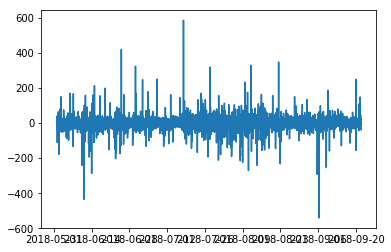

In [4]:
#30min的图
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap30', date_type='datetime')["BTCUSDT:binance"])
plt.show()

In [5]:
Gap1H = dv1H.add_formula('gap1H', 'close-Delay(open, 1)',add_data=True)

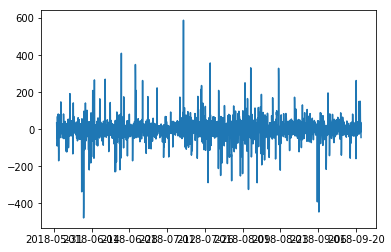

In [6]:
import matplotlib.pyplot as plt


plt.plot(dv1H.get_ts('gap1H', date_type='datetime')["BTCUSDT:binance"])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [7]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),\
                      If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [8]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()

In [9]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

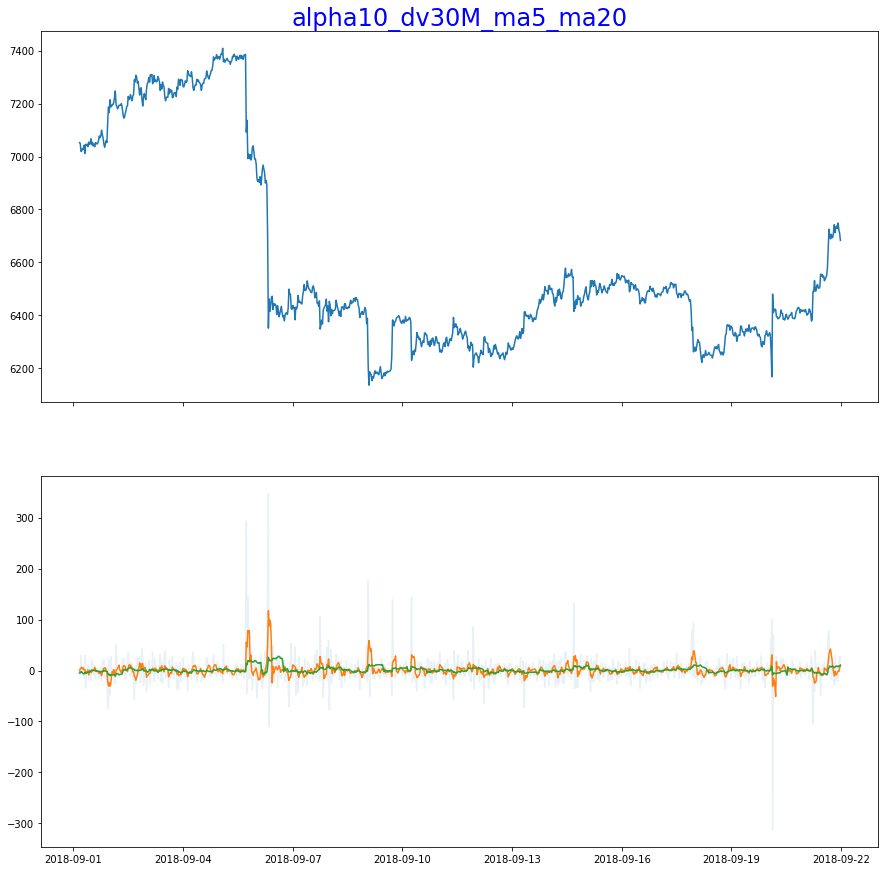

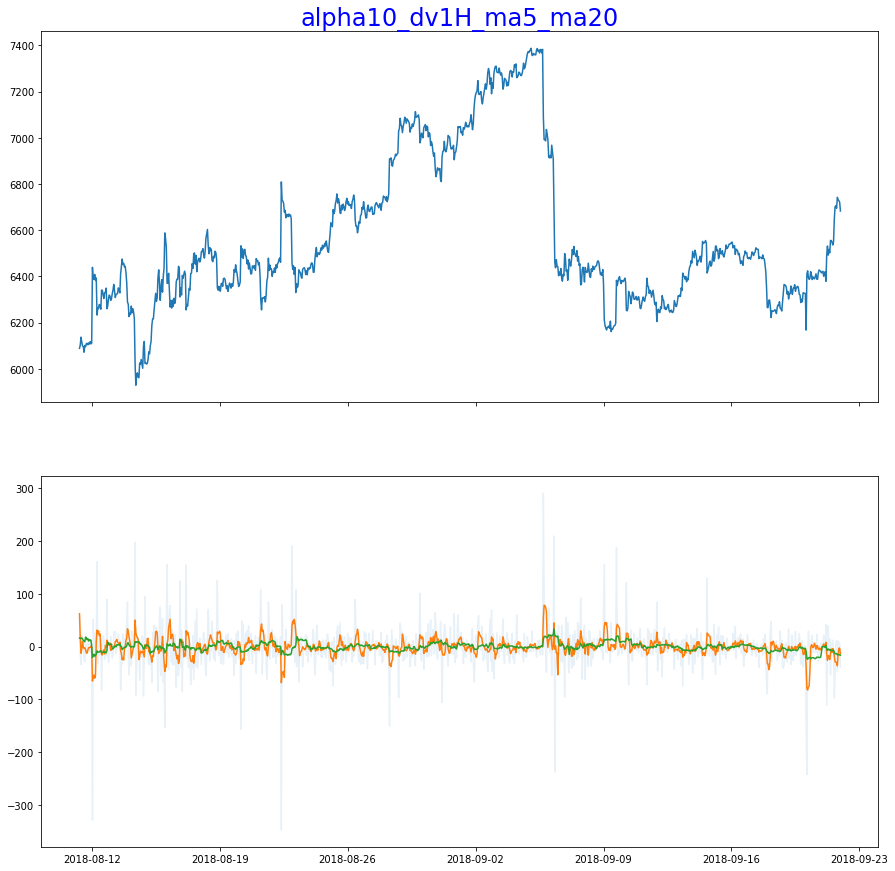

In [10]:
import pandas as pd
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',\
              ShortPeriod=5, LongPeriod=20, n=-1000)

In [11]:
long = dv1H.add_formula("longAlpha1","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha1","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

close_long = dv1H.add_formula("closeLongAlpha1","If(shortAlpha1==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha1","If(longAlpha1==2,-1,0)", add_data=True)

In [12]:
dv1H.get_ts('longAlpha1').stack()[dv1H.get_ts('longAlpha1').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [13]:
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')
tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')
def TimingSignal(td, dv, long, short,closeLong, closeShort, mhp,sl,sp):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [14]:
TimingSignal(tdAlpha1, dv1H,long='longAlpha1',short='shortAlpha1',closeLong='closeLongAlpha1',\
             closeShort='closeShortAlpha1', mhp=100, sl=0.05, sp=0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [15]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [16]:
import warnings
warnings.filterwarnings("ignore")

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

In [17]:
data1H = Time_dict.set_index('datetime')

In [18]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [19]:
import matplotlib.pyplot as plt
#import mpl_finance as mpf
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [20]:
Morning_star=dv1H.add_formula('Morning_star',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),\
                            100,0)",add_data=True)

In [21]:
MoringstarVolume=dv1H.get_ts('Morning_star', date_type='datetime')
MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [22]:
MoringstarVolumeX = MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100].index
MoringstarVolumeY = data1H.loc[MoringstarVolumeX].low-100

In [23]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

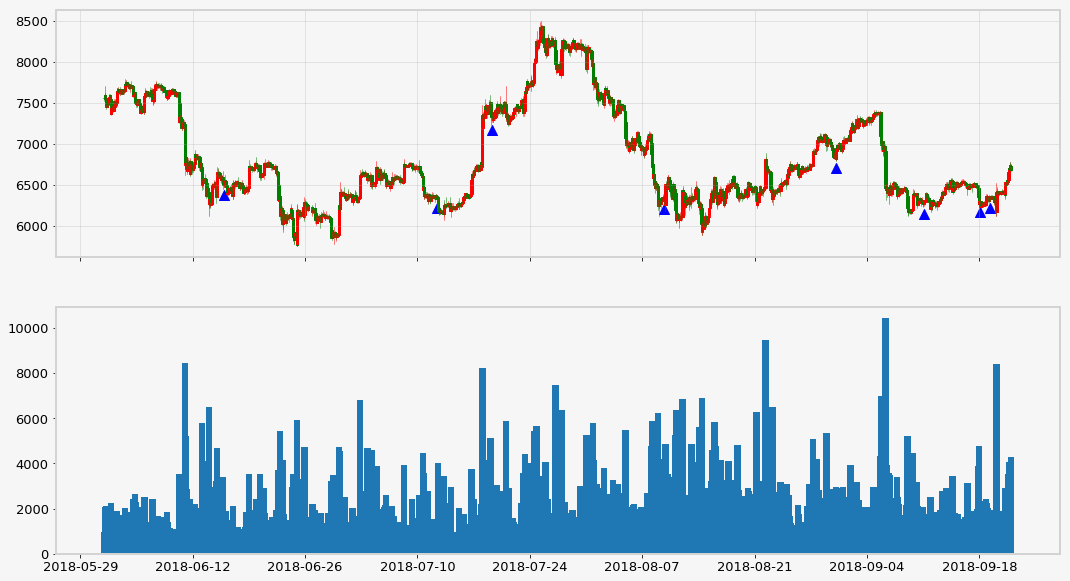

In [24]:
draw_candle(candle, MoringstarVolumeX, MoringstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
#读取数据：
#数据类型：BTCUSDT:binance
#数据周期：1小时K线图
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol':'BTCUSDT:binance','freq':"1H",
         'start_date':20180701000000}  #起始时间：2018.07.01

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.212785243988037


In [2]:
#数据初始化
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H_new = HFDataView()
dv1H_new.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [3]:
#1.调用因子1:ROC-价格变化率
ROC12=dv1H_new.add_formula('ROC12', '((close/Delay(close,12))-1)*100',add_data=True)#采用市场流行的12天价格变化率

In [4]:
import matplotlib.pyplot as plt

def plot_chart1(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:],'r', label='ROC_12')
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

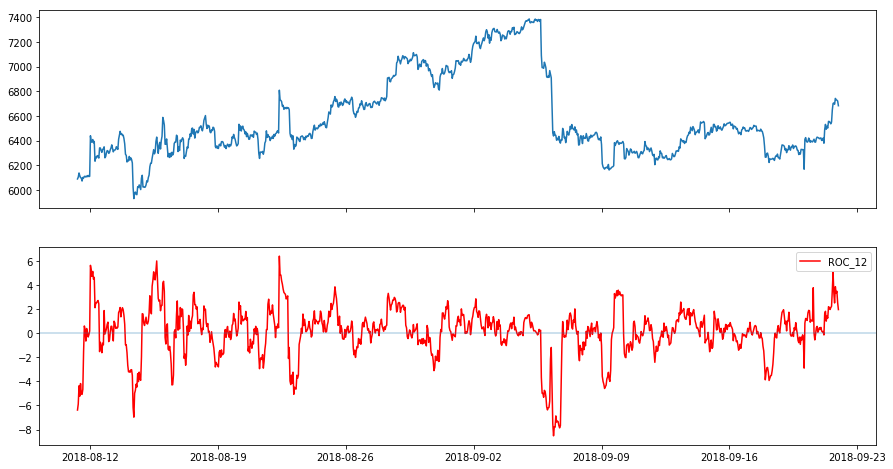

In [5]:
ROC_plot = dv1H_new.get_ts('ROC12', date_type='datetime')
close1 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart1(close1, ROC_plot)

In [6]:
#因子1研究报告
#因子：调用技术因子ROC
#现象：来反映股票市股价变动的快慢程度，显示当前股价趋势的加速和减速状态
#描述：ROC表示股价上升或下降的速率大小。
    #如果是上升趋势，并且ROC为正值,另外ROC步步上扬,则意味着上升趋势正在加速，若ROC开始走平,这就意味着,
    #股价的涨幅与数天前的股价涨幅相近,尽管还处于上升趋势,但速度已经放慢;若ROC开始回落,虽然股价还在上升,但上升的力量已经衰落;
    #若ROC开始延伸到0之下,下降趋势已开始露头,ROC进一步向下,则下降动力正在加强。
    #下降趋势类似
#适用于波段行情，实现超买超卖进出场。

In [7]:
#2.调用因子2:MACD与RSI结合

In [8]:
#MACD为趋势指标，用于趋势判断，观察价格上升下降趋势，RSI为强弱类指标，判断买方市场与卖方市场力量强弱对比。

In [9]:
DIFF = dv1H_new.add_formula('DIFF',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",add_data=True)
DEA = dv1H_new.add_formula('DEA', "Ta('EMA',0,0,0,0,DIFF,0,9)", add_data=True)
MACD = dv1H_new.add_formula('MACD',"(DIFF-DEA)*2",add_data=True)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_chart2(close,alpha1,alpha2,histogram):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-300:],"b",label="MACD")
    ax1.plot(alpha1.iloc[-300:],'g', label='DIFF')
    ax1.plot(alpha2.iloc[-300:],'r', label='DEA')
    ax1.bar(close.iloc[-300:].index ,histogram.iloc[-300:],width = 0.1)
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

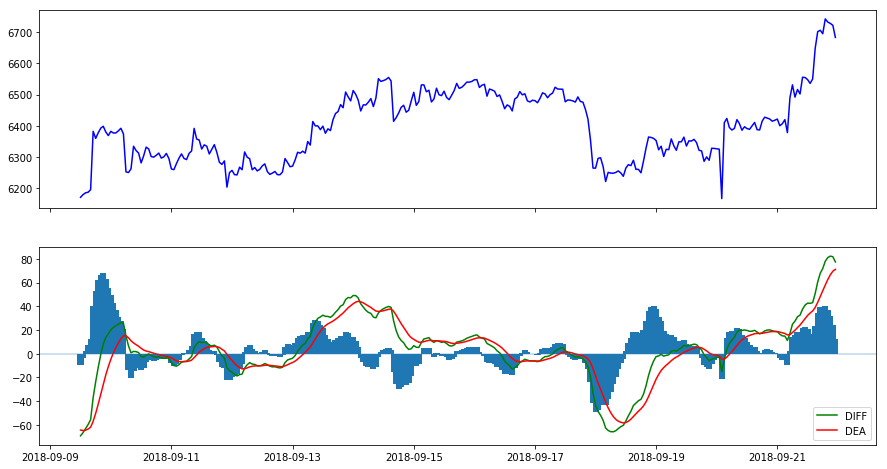

In [11]:
DIFF_plot = dv1H_new.get_ts('DIFF', date_type='datetime')
DEA_plot = dv1H_new.get_ts('DEA', date_type='datetime')
MACD_plot = dv1H_new.get_ts('MACD', date_type='datetime')
close2 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart2(close2.iloc[:,0],DIFF_plot.iloc[:,0],DEA_plot.iloc[:,0],MACD_plot.iloc[:,0])  

In [12]:
dv1H_new.add_formula('Ui_12',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_new.add_formula('Di_12',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_new.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui_12,Ui_12,Ui_12,Ui_12,\
                        Ui_12,12)/Ta('MA',0,Di_12,Di_12,Di_12,Di_12,Di_12,12)))",add_data=True)

dv1H_new.add_formula('Ui_6',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_new.add_formula('Di_6',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_new.add_formula('RSI_6',"100-100/(1+(Ta('MA',0,Ui_6,Ui_6,Ui_6,Ui_6,\
                    Ui_6,6)/Ta('MA',0,Di_6,Di_6,Di_6,Di_6,Di_6,6)))",add_data=True)

In [13]:
import matplotlib.pyplot as plt

def plot_chart3(close,alpha1,alpha2):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha1.iloc[-1000:],'g', label='RSI_12')
    ax1.plot(alpha2.iloc[-1000:],'r', label='RSI_6')
    ax1.axhline(80,alpha=0.3,)
    ax1.axhline(20,alpha=0.3,)
    plt.legend()
    plt.show()

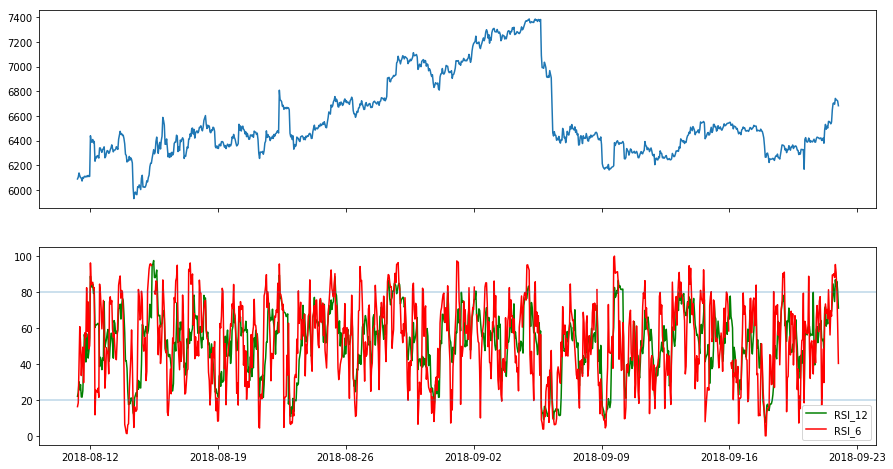

In [14]:
RSI_plot_12 = dv1H_new.get_ts('RSI_12', date_type='datetime')
RSI_plot_6 = dv1H_new.get_ts('RSI_6', date_type='datetime')
close3 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart3(close1, RSI_plot_12,RSI_plot_6)

In [15]:
#因子2研究报告
#因子2.1：调用技术因子MACD,分别添加了差离值DIFF,差离值9日移动平均线DEA，以及MACD柱。
#现象：画图比较了股价可能的发展变化趋势以及多空双方的强弱状态。
#描述：当MACD柱大于0时，表示趋势向上，行情处于多头市场；小于0时，表示趋势向下，行情处于空头市场，同时，柱状线越长，趋势越强。
     #当DIF和DEA均大于0并向上移动时，一般表示为行情处于多头行情中，可以买入开仓或多头持仓；
     #当DIF和DEA均小于0并向下移动时，一般表示为行情处于空头行情中，可以卖出开仓或观望。
     #当DIF和DEA均大于0但都向下移动时，一般表示为行情处于下跌阶段，可以卖出开仓和观望；
     #当DIF和DEA均小于0时但向上移动时，一般表示为行情即将上涨，股票将上涨，可以买入开仓或多头持仓。
#因子2.2：调用技术因子RSI,分别是6日短期RSI与12日长期RSI
#现象：画图比较了股票收盘价与多空双方买卖力量相对强弱的关系。
#描述：当RSI取值为50时，股票的买入力量与卖出力量一致，股价不变，RSI取值越大，股票买入力度越大，股票价格会上涨；
     #RSI取值越小，股票卖出力度越大，股票价格会下跌。同时，短期RSI大于长期RSI为多头市场，反之为空头市场。

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [16]:
#因子1:ROC-价格变化率
#联系：ROC是显示一定时间间隔的两头的股价的相对差价。ROC上升,则股价涨幅比数天前的股价有所上升。
      #ROC走平，则当前股价涨幅仅仅同数天前一样。ROC向下，则股价已经比数天前的涨幅小了。
      #ROC的变化总是领先于股价的变化，比价格提前几天上升或下降
#信号：ROC值是否穿过0基准线。ROC自上而下跌破0,是卖出信号。反之，ROC自下而上穿过0,是买进信号。
      #由于其变化具有领先性，所以当ROC变化时，价格可能还没变化；同时，ROC指标由于其特性具有十分敏感的性质，尤其在0线附近。
      #为了避免以上问题，可以适当增大阈值来提高收益率。修正后为ROC自上而下跌破-1,是卖出信号。反之，ROC自下而上穿过1,是买进信号。
#信号进出场假设：
#进场信号，如果出现12日ROC>1且前一个小时的12日ROC<1的信号时,买入,做多;如果出现12日ROC<-1且前一个小时的12日ROC>-1的信号时,卖出,做空。
#出场信号，如果出现12日ROC<1且前一个小时的12日ROC>1的信号时,平多单;如果出现12日ROC>-1且前一个小时的12日ROC<-1的信号时,平空单。

In [125]:
#进场信号
ROClong = dv1H_new.add_formula("ROCLong","If((ROC12>1) && (Delay(ROC12,1)<1),2,0)",add_data=True)
ROCshort = dv1H_new.add_formula("ROCShort","If((ROC12<-1) && (Delay(ROC12,1)>-1),-2,0)",add_data=True)
#出场信号
ROCcloselong = dv1H_new.add_formula("ROCcloseLong","If(ROCShort==-2,1,0)",add_data=True)
ROCcloseshort = dv1H_new.add_formula("ROCcloseShort","If(ROCLong==2,-1,0)",add_data=True)

Field [ROCLong] is overwritten.
Field [ROCShort] is overwritten.
Field [ROCcloseLong] is overwritten.
Field [ROCcloseShort] is overwritten.


In [119]:
dv1H_new.get_ts("ROCLong").stack()[dv1H_new.get_ts("ROCLong").stack()==2].head()

trade_date      symbol         
20180702210000  BTCUSDT:binance    2.0
20180704210000  BTCUSDT:binance    2.0
20180705010000  BTCUSDT:binance    2.0
20180708070000  BTCUSDT:binance    2.0
20180715230000  BTCUSDT:binance    2.0
dtype: float64

In [19]:
#因子2:MACD-异同移动平均线与RSI-相对强弱指标共同联用
#联系1(MACD)：是趋势指标，判断股价未来涨跌的变化趋势；由快、慢均线的离散、聚合表征当前的多空状态和股价可能的发展变化趋势。
            #当MACD柱从负数转向正数，是买的信号。当MACD从正数转向负数，是卖的信号。
#联系2(RSI)：买方和卖方力量的消长会影响股票的价格。买方力量大，股票上涨；卖方力量大，股票下跌。RSI是衡量买卖双方力量强弱的指标。
#信号1：MACD金叉：DIFF 由下向上突破 DEA，为买入信号；MACD死叉：DIFF 由上向下突破 DEA，为卖出信号
#信号2：当RSI大于50时，股票处于买方强势区，所以股票价格可能会上涨。当RSI小于50时，股票处于卖方强势区，所以股票价格可能会下跌。
      #短期RSI由下往上交叉长期RSI，多头市场占主要优势，为买进信号；短期RSI由上往下交叉长期RSI，空头市场占主要优势，为卖出信号。
#信号进出场假设：
#进场信号，当短期RSI大于50，出现短期RSI由下向上交叉长期RSI的金叉现象，且同时满足DIFF 由下向上突破 DEA，买入，做多。
         #当短期RSI小于50，出现短期RSI由上向下交叉长期RSI的死叉现象，且同时满足DIFF 由上向下突破 DEA，卖出，做空。
#出场信号，当买入信号任一条件不满足时，平多单；当卖出信号任一条件不满足时，平空单

In [20]:
#进场信号
RSIlong = dv1H_new.add_formula("RSI_MACD_Long","If((RSI_6>50)&&(RSI_6>RSI_12)&&(Delay(RSI_6,1)<=Delay(RSI_12,1))\
                               &&((DIFF>DEA)&&(Delay(DIFF,1)<=Delay(DEA,1))),2,0)",add_data=True)
RSIshort = dv1H_new.add_formula("RSI_MACD_Short","If((RSI_6<50)&&(RSI_6<RSI_12)&&(Delay(RSI_6,1)>=Delay(RSI_12,1))\
                               &&((DIFF<DEA)&&(Delay(DIFF,1)>=Delay(DEA,1))),-2,0)",add_data=True)
#出场信号
RSIcloselong = dv1H_new.add_formula("RSI_MACD_closeLong","If(RSI_MACD_Short==-2,1,0)",add_data=True)
RSIcloseshort = dv1H_new.add_formula("RSI_MACD_closeShort","If(RSI_MACD_Long==2,-1,0)",add_data=True) 

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [21]:
#因子1:ROC-价格变化率   假设落实

In [126]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [127]:
tdROC = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC12')
TimingSignal(tdROC,dv1H_new,"ROCLong","ROCShort","ROCcloseLong","ROCcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [128]:
tdROC.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               7.261  -14.201    1.447
p-value              0.000    0.000    0.150
mean                 0.035   -0.015    0.004
std                  0.039    0.011    0.035
info_ratio           0.908   -1.373    0.110
skewness             1.993   -1.250    2.293
kurtosis             3.690    2.399    7.052
pct5                 0.002   -0.032   -0.029
pct25                0.010   -0.021   -0.016
pct50                0.023   -0.013   -0.006
pct75                0.042   -0.007    0.013
pct95                0.120   -0.002    0.065
occurance           65.000  108.000  173.000
win_ratio              NaN      NaN    0.376
win_mean/loss_mean     NaN      NaN    2.349


In [129]:
tdROC.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               6.257 -11.565    1.925
p-value              0.000   0.000    0.057
mean                 0.044  -0.015    0.008
std                  0.044   0.010    0.041
info_ratio           1.002  -1.457    0.190
skewness             1.612  -1.076    2.113
kurtosis             1.633   1.145    4.979
pct5                 0.006  -0.034   -0.032
pct25                0.015  -0.019   -0.016
pct50                0.030  -0.013   -0.006
pct75                0.048  -0.008    0.017
pct95                0.156  -0.002    0.102
occurance           40.000  64.000  104.000
win_ratio              NaN     NaN    0.385
win_mean/loss_mean     NaN     NaN    2.924


In [130]:
tdROC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.977  -8.311  -0.716
p-value              0.000   0.000   0.477
mean                 0.020  -0.015  -0.002
std                  0.020   0.012   0.023
info_ratio           1.016  -1.267  -0.087
skewness             1.127  -1.444   0.952
kurtosis             0.485   3.576   1.802
pct5                 0.001  -0.029  -0.029
pct25                0.005  -0.022  -0.017
pct50                0.012  -0.012  -0.005
pct75                0.034  -0.006   0.006
pct95                0.057  -0.001   0.040
occurance           25.000  44.000  69.000
win_ratio              NaN     NaN   0.362
win_mean/loss_mean     NaN     NaN   1.389


In [27]:
#因子2:MACD-异同移动平均线与RSI-相对强弱指标组合   假设落实

In [28]:
tdRSI_MACD = TimingDigger(output_folder=".", output_format='pdf',signal_name='RSI_MACD')
TimingSignal(tdRSI_MACD,dv1H_new,"RSI_MACD_Long","RSI_MACD_Short","RSI_MACD_closeLong","RSI_MACD_closeShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [29]:
tdRSI_MACD.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.542  -4.434   1.027
p-value              0.004   0.002   0.315
mean                 0.044  -0.031   0.011
std                  0.043   0.021   0.051
info_ratio           1.022  -1.478   0.219
skewness             2.162   0.008   1.194
kurtosis             4.309  -1.718   2.463
pct5                 0.005  -0.056  -0.055
pct25                0.021  -0.054  -0.019
pct50                0.031  -0.030   0.007
pct75                0.054  -0.010   0.031
pct95                0.111  -0.005   0.066
occurance           13.000  10.000  23.000
win_ratio              NaN     NaN   0.565
win_mean/loss_mean     NaN     NaN   1.404


In [30]:
tdRSI_MACD.create_event_report(sig_type="long")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              2.404 -2.890   1.313
p-value             0.053  0.102   0.222
mean                0.053 -0.034   0.027
std                 0.054  0.017   0.061
info_ratio          0.981 -2.043   0.438
skewness            1.542  0.152   1.134
kurtosis            1.031 -1.500   1.068
pct5                0.011 -0.052  -0.046
pct25               0.021 -0.045  -0.008
pct50               0.025 -0.036   0.021
pct75               0.060 -0.025   0.046
pct95               0.144 -0.015   0.127
occurance           7.000  3.000  10.000
win_ratio             NaN    NaN   0.700
win_mean/loss_mean    NaN    NaN   1.535


In [31]:
tdRSI_MACD.create_event_report(sig_type="short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              4.002 -3.237  -0.075
p-value             0.010  0.018   0.941
mean                0.033 -0.030  -0.001
std                 0.018  0.022   0.037
info_ratio          1.790 -1.322  -0.022
skewness           -0.203 -0.102  -0.083
kurtosis           -1.011 -1.805  -1.138
pct5                0.007 -0.056  -0.056
pct25               0.025 -0.054  -0.024
pct50               0.031 -0.024  -0.003
pct75               0.049 -0.008   0.031
pct95               0.055 -0.004   0.055
occurance           6.000  7.000  13.000
win_ratio             NaN    NaN   0.462
win_mean/loss_mean    NaN    NaN   1.107


策略通用性测试：
#品种：EOSUSDT:binance
#测试周期：1小时K线图

In [88]:
#读取数据：
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props_uni = {'fields': 'open,high,low,close,volume','symbol':'EOSUSDT:binance','freq':"1H",
         'start_date':20180801000000}  #起始时间是2018.08.01

Time_dict_uni = ds.bar_reader(path,props_uni)
print(time()-start)

1.3292179107666016


In [89]:
#数据初始化
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H_uni = HFDataView()
dv1H_uni.create_init_dv(Time_dict_uni.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [90]:
#1、因子1 ROC-价格变化率 策略通用性测试

In [91]:
ROC12=dv1H_uni.add_formula('ROC12', '((close/Delay(close,12))-1)*100',add_data=True)#采用市场流行的12天价格变化率

In [92]:
import matplotlib.pyplot as plt

def plot_chart1(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close)
    ax1.plot(alpha,'r', label='ROC_12')
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

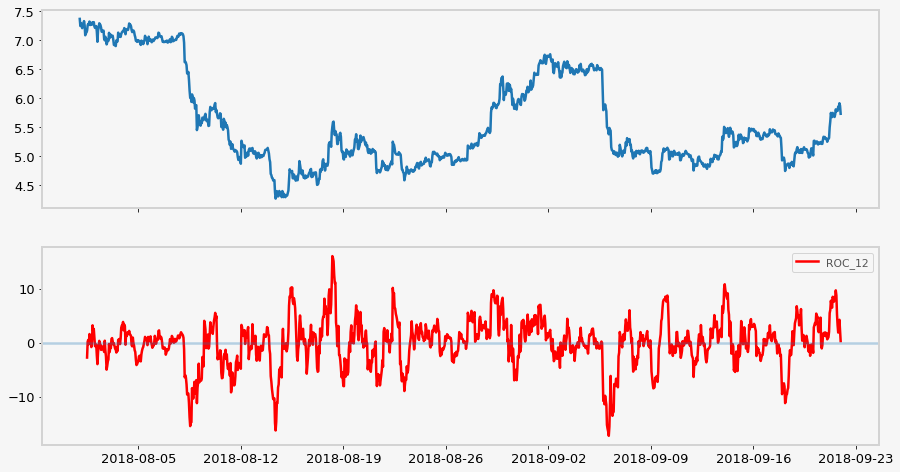

In [93]:
ROC_plot = dv1H_uni.get_ts('ROC12', date_type='datetime')
close1 = dv1H_uni.get_ts('close', date_type='datetime')
plot_chart1(close1, ROC_plot)

In [94]:
#进场信号,如果出现12日ROC>2且前一个小时的12日ROC<2的信号时,买入,做多;如果出现12日ROC<-2且前一个小时的12日ROC>-2的信号时,卖出,做空。
ROClong = dv1H_uni.add_formula("ROCLong","If((ROC12>2) && (Delay(ROC12,1)<2),2,0)",add_data=True)
ROCshort = dv1H_uni.add_formula("ROCShort","If((ROC12<-2) && (Delay(ROC12,1)>-2),-2,0)",add_data=True)
#出场信号,如果出现12日ROC<2且前一个小时的12日ROC>2的信号时,平多单;如果出现12日ROC>-2且前一个小时的12日ROC<-2的信号时,平空单。
ROCcloselong = dv1H_uni.add_formula("ROCcloseLong","If(ROCShort==-2,1,0)",add_data=True)
ROCcloseshort = dv1H_uni.add_formula("ROCcloseShort","If(ROCLong==2,-1,0)",add_data=True)

In [95]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [96]:
tdROC = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC12')
TimingSignal(tdROC,dv1H_uni,"ROCLong","ROCShort","ROCcloseLong","ROCcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%


In [97]:
tdROC.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.775 -12.703    2.092
p-value              0.000   0.000    0.039
mean                 0.056  -0.029    0.011
std                  0.048   0.018    0.055
info_ratio           1.173  -1.588    0.190
skewness             1.203  -0.769    1.136
kurtosis             1.013   0.380    1.248
pct5                 0.002  -0.062   -0.056
pct25                0.019  -0.039   -0.027
pct50                0.048  -0.026   -0.005
pct75                0.079  -0.015    0.042
pct95                0.150  -0.004    0.128
occurance           57.000  65.000  122.000
win_ratio              NaN     NaN    0.467
win_mean/loss_mean     NaN     NaN    1.907


In [98]:
tdROC.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               6.832  -8.648   2.066
p-value              0.000   0.000   0.043
mean                 0.058  -0.029   0.014
std                  0.049   0.019   0.057
info_ratio           1.189  -1.505   0.252
skewness             1.252  -0.939   1.069
kurtosis             0.937   0.657   1.096
pct5                 0.009  -0.059  -0.055
pct25                0.021  -0.043  -0.022
pct50                0.043  -0.022  -0.000
pct75                0.077  -0.016   0.041
pct95                0.152  -0.004   0.134
occurance           34.000  34.000  68.000
win_ratio              NaN     NaN   0.500
win_mean/loss_mean     NaN     NaN   1.992


In [99]:
tdROC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.405  -9.275   0.772
p-value              0.000   0.000   0.444
mean                 0.053  -0.030   0.006
std                  0.046   0.017   0.052
info_ratio           1.152  -1.693   0.106
skewness             1.096  -0.511   1.208
kurtosis             1.012  -0.153   1.393
pct5                 0.003  -0.061  -0.055
pct25                0.011  -0.039  -0.029
pct50                0.051  -0.028  -0.007
pct75                0.080  -0.017   0.039
pct95                0.136  -0.005   0.093
occurance           23.000  31.000  54.000
win_ratio              NaN     NaN   0.426
win_mean/loss_mean     NaN     NaN   1.788


In [100]:
#2、因子2:MACD-异同移动平均线与RSI-相对强弱指标组合   策略通用性测试

In [101]:
DIFF = dv1H_uni.add_formula('DIFF',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",add_data=True)
DEA = dv1H_uni.add_formula('DEA', "Ta('EMA',0,0,0,0,DIFF,0,9)", add_data=True)
MACD = dv1H_uni.add_formula('MACD',"(DIFF-DEA)*2",add_data=True)

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_chart2(close,alpha1,alpha2,histogram):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-300:],"b",label="MACD")
    ax1.plot(alpha1.iloc[-300:],'g', label='DIFF')
    ax1.plot(alpha2.iloc[-300:],'r', label='DEA')
    ax1.bar(close.iloc[-300:].index ,histogram.iloc[-300:],width = 0.1)
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

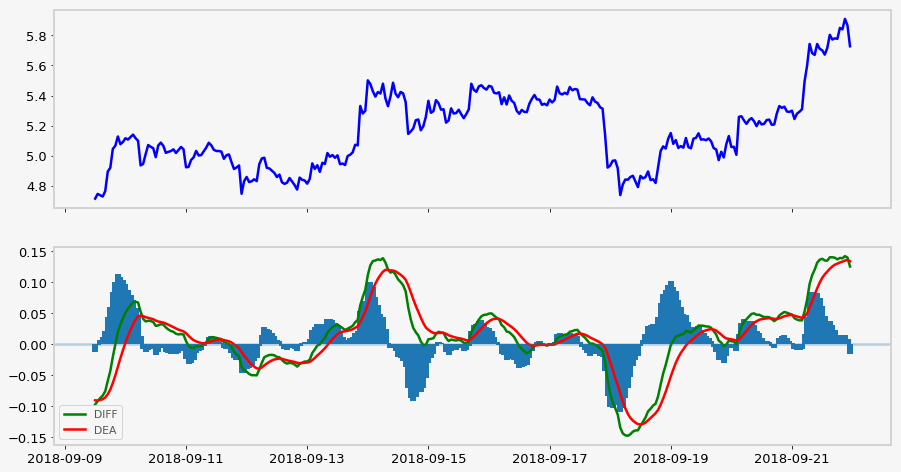

In [103]:
DIFF_plot = dv1H_uni.get_ts('DIFF', date_type='datetime')
DEA_plot = dv1H_uni.get_ts('DEA', date_type='datetime')
MACD_plot = dv1H_uni.get_ts('MACD', date_type='datetime')
close2 = dv1H_uni.get_ts('close', date_type='datetime')
plot_chart2(close2.iloc[:,0],DIFF_plot.iloc[:,0],DEA_plot.iloc[:,0],MACD_plot.iloc[:,0])  

In [104]:
dv1H_uni.add_formula('Ui_12',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_uni.add_formula('Di_12',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_uni.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui_12,Ui_12,Ui_12,Ui_12,\
                        Ui_12,12)/Ta('MA',0,Di_12,Di_12,Di_12,Di_12,Di_12,12)))",add_data=True)

dv1H_uni.add_formula('Ui_6',"If(close>Delay(close,1),close-Delay(close,1),\
                    If(close<Delay(close,1),0,0))",add_data=True)
dv1H_uni.add_formula('Di_6',"If(close>Delay(close,1),0,If(close<Delay(close,1),\
                    Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_uni.add_formula('RSI_6',"100-100/(1+(Ta('MA',0,Ui_6,Ui_6,Ui_6,Ui_6,\
                    Ui_6,6)/Ta('MA',0,Di_6,Di_6,Di_6,Di_6,Di_6,6)))",add_data=True)

In [105]:
import matplotlib.pyplot as plt

def plot_chart3(close,alpha1,alpha2):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha1.iloc[-1000:],'g', label='RSI_12')
    ax1.plot(alpha2.iloc[-1000:],'r', label='RSI_6')
    ax1.axhline(80,alpha=0.3,)
    ax1.axhline(20,alpha=0.3,)
    plt.legend()
    plt.show()

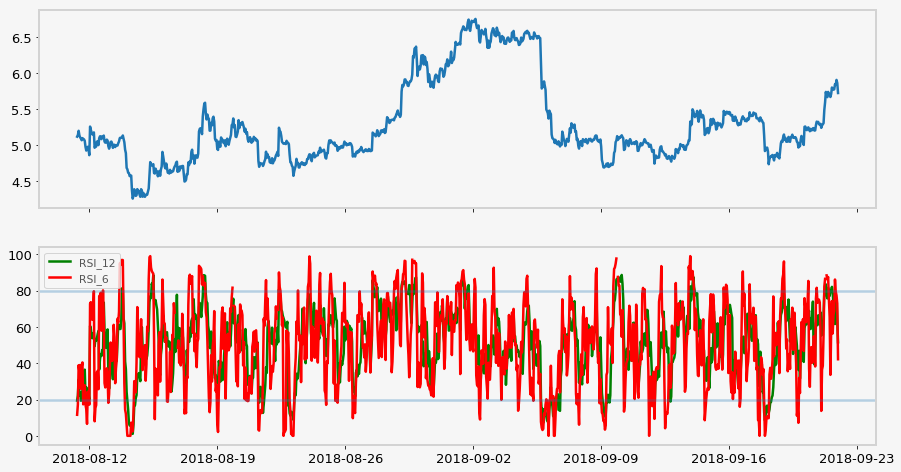

In [106]:
RSI_plot_12 = dv1H_uni.get_ts('RSI_12', date_type='datetime')
RSI_plot_6 = dv1H_uni.get_ts('RSI_6', date_type='datetime')
close3 = dv1H_uni.get_ts('close', date_type='datetime')
plot_chart3(close3, RSI_plot_12,RSI_plot_6)

In [107]:
#进场信号，当短期RSI大于50，出现短期RSI由下向上交叉长期RSI的金叉现象，且同时满足DIFF 由下向上突破 DEA，买入，做多。
         #当短期RSI小于50，出现短期RSI由上向下交叉长期RSI的死叉现象，且同时满足DIFF 由上向下突破 DEA，卖出，做空。
RSIlong = dv1H_uni.add_formula("RSI_MACD_Long","If((RSI_6>50)&&(RSI_6>RSI_12)&&(Delay(RSI_6,1)<=Delay(RSI_12,1))\
                               &&((DIFF>DEA)&&(Delay(DIFF,1)<=Delay(DEA,1))),2,0)",add_data=True)
RSIshort = dv1H_uni.add_formula("RSI_MACD_Short","If((RSI_6<50)&&(RSI_6<RSI_12)&&(Delay(RSI_6,1)>=Delay(RSI_12,1))\
                               &&((DIFF<DEA)&&(Delay(DIFF,1)>=Delay(DEA,1))),-2,0)",add_data=True)
#出场信号，当买入信号任一条件不满足时，平多单；当卖出信号任一条件不满足时，平空单
RSIcloselong = dv1H_uni.add_formula("RSI_MACD_closeLong","If(RSI_MACD_Short==-2,1,0)",add_data=True)
RSIcloseshort = dv1H_uni.add_formula("RSI_MACD_closeShort","If(RSI_MACD_Long==2,-1,0)",add_data=True) 

In [108]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [109]:
tdRSI_MACD = TimingDigger(output_folder=".", output_format='pdf',signal_name='RSI_MACD')
TimingSignal(tdRSI_MACD,dv1H_uni,"RSI_MACD_Long","RSI_MACD_Short","RSI_MACD_closeLong","RSI_MACD_closeShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%


In [110]:
tdRSI_MACD.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              3.371 -2.561   2.138
p-value             0.012  0.125   0.058
mean                0.105 -0.041   0.065
std                 0.082  0.023   0.096
info_ratio          1.274 -1.811   0.676
skewness            0.421  0.583   0.488
kurtosis           -1.354 -1.500  -0.983
pct5                0.010 -0.061  -0.057
pct25               0.048 -0.057   0.000
pct50               0.073 -0.051   0.060
pct75               0.176 -0.030   0.119
pct95               0.228 -0.014   0.225
occurance           8.000  3.000  11.000
win_ratio             NaN    NaN   0.727
win_mean/loss_mean    NaN    NaN   2.565


In [111]:
tdRSI_MACD.create_event_report(sig_type="long")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win      loss    all
t-stat              2.042       NaN  1.428
p-value             0.134       NaN  0.227
mean                0.097 -0.051000  0.068
std                 0.083  0.000000  0.095
info_ratio          1.179      -inf  0.714
skewness            0.806  0.000000  0.628
kurtosis           -0.851 -3.000000 -0.616
pct5                0.019 -0.051000 -0.039
pct25               0.055 -0.051000  0.010
pct50               0.073 -0.051000  0.071
pct75               0.115 -0.051000  0.075
pct95               0.210 -0.051000  0.202
occurance           4.000  1.000000  5.000
win_ratio             NaN       NaN  0.800
win_mean/loss_mean    NaN       NaN  1.905


In [112]:
tdRSI_MACD.create_event_report(sig_type="short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              2.393 -1.366  1.444
p-value             0.096  0.402  0.208
mean                0.113 -0.036  0.063
std                 0.082  0.026  0.098
info_ratio          1.382 -1.366  0.646
skewness            0.039  0.000  0.386
kurtosis           -1.634 -2.000 -1.273
pct5                0.018 -0.059 -0.049
pct25               0.048 -0.049 -0.004
pct50               0.111 -0.036  0.035
pct75               0.176 -0.023  0.137
pct95               0.209 -0.012  0.204
occurance           4.000  2.000  6.000
win_ratio             NaN    NaN  0.667
win_mean/loss_mean    NaN    NaN  3.141
